In [453]:
#%pip install gym
#%pip install numpy
#%pip install stable_baselines3
#%pip install matplotlib
#%pip install tabulate

In [454]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
import math

np.random.seed(909)

T_episode = 8 

# Model Defintion
## We use gym library to create an Environment Model: States, Actions, Observations and variables which define environment parameters

class ChargingEnvironment(gym.Env):
    def __init__(self):
        super(ChargingEnvironment, self).__init__()
        self.seed_val = 808 
        self.np_random, _ = gym.utils.seeding.np_random(self.seed_val)

        # Create Action and Observation Space
        self.action_space = spaces.Discrete(4) # 4 charging rates -> Discrete action space with 4 actions 
        self.observation_space = spaces.Box(low=0, high=50, shape=(2,), dtype=np.float32) # Define maximum vehicle battery as 50. With given charging rates and episode length, the agent could only reach the max capacity/overcharge during the first episode.

        # CONSTANTS / LOOKUP TABLES
        # Time coefficients
        self.alpha = np.array([0.7, 0.8, 0.9, 1, 1, 1, 1, 1])

        # Energy Demand: Modelled as normal distribution with mean = 30kW and variance = 5kw 
        self.mu = 30
        self.sigma = 5

        # Charging rates: Lookup table for discretised values (0 -> zero , 6 -> low, 18 -> medium, 22 -> high)
        self.charging_powers = np.array([0, 12, 18, 22])

        # State-related Variables
        self.residual_battery = 0
        self.missed_demand = 0
        self.state = np.array([4, 50], dtype=np.float32)  # Initialize state with battery level of 20
        self.cumulative_charging_cost = 0  # Cumulative charging cost
        self.cumulative_penalty = 0  # Cumulative penalty

    # Step function which simulates one time-step of agent-environment interaction 
    def step(self, action):
        # Get state
        time, battery_level = self.state
        charging_power = self.charging_powers[action]
        battery_level = min(50, battery_level + charging_power/4)
        # Update time-step within episode (T=8)
        time += 1

        self.state = np.array([time, battery_level])
        self.n_energy_penalty = 0  
        self.missed_demand = 0 
        charging_cost = -self.alpha[int(time) - 1] * np.exp(charging_power)

        reward = 0
        penalty = 0
        energy_met = None

        if time == T_episode:  # Last time step
            energy_demand = self.np_random.normal(self.mu, self.sigma)
            if battery_level < energy_demand:  
                self.missed_demand = energy_demand - battery_level 
                penalty = -np.exp(22) * 8 * self.missed_demand
                energy_met = False
                self.n_energy_penalty += 1
            else:
                energy_met = True
                reward += np.exp(22)*6  # Reward for meeting the energy demand

            self.residual_battery = max(0, battery_level - energy_demand)

        reward = reward + charging_cost + penalty
        done = time == T_episode

        # Cumulative calculations
        if time == 1:  # First time step
            self.cumulative_reward = reward
            self.cumulative_charging_cost = charging_cost
            self.cumulative_penalty = penalty
        else:
            self.cumulative_reward = (self.cumulative_reward * (time - 1) + reward) / time
            self.cumulative_charging_cost = (self.cumulative_charging_cost * (time - 1) + charging_cost) / time
            self.cumulative_penalty = (self.cumulative_penalty * (time - 1) + penalty) / time

        return self.state, reward, done, {'energy_met': energy_met, 'instant_reward': reward, 'average_reward': self.cumulative_reward, 'charging_cost': charging_cost, 'penalty': penalty, 'cumulative_charging_cost': self.cumulative_charging_cost, 'cumulative_penalty': self.cumulative_penalty, 'missed_demand': self.missed_demand}

    def reset(self):
        #Define how the environment is "reset" for the next episode -> For simplicity / fully discretised state space: Agent always restarts with a battery level of 0 (instead of i.e residual energy from last episode).
        self.state = np.array([0, 0], dtype=np.float32)
        self.cumulative_charging_cost = 0
        self.cumulative_penalty = 0
        self.missed_demand = 0
        return self.state

In [455]:
def run_episode(model, env):
    """
    Perform one episode of 8 timesteps with the given model in the provided environment.
    """
    obs = env.reset()
    rewards = []
    current_average_rewards = []  # Store average rewards for current epsilon

    for _ in range(8):  
        action, _states = model.predict(obs, deterministic=True)
        charging_power = env.charging_powers[action]
        obs, reward, done, info = env.step(action)
        energy_met = info['energy_met']
        instant_reward = info['instant_reward']
        rewards.append(instant_reward)
        average_reward = sum(rewards) / len(rewards)
        current_average_rewards.append(average_reward)
        
        print(f"Action: {action}, Charging Power: {charging_power} kW, Reward: {reward}")
        print(f"Current Battery Level: {obs[1]} kWh")
        
        if done:
            print(f"Energy Demand Met: {energy_met}")
            print(f"Missed Demand: {info['missed_demand']} kWh")  # Display missed demand

    return current_average_rewards


# Define parameters for training loop
average_rewards = []
initial_eps_values = [0.0, 0.2, 0.5, 0.8, 1]
n_energy_penalty_eps = []
env = ChargingEnvironment()

# For each parameter: Train a model and perform one episode with trained policy
n_eps_train = 365
for initial_eps in initial_eps_values:
    model = DQN("MlpPolicy", env, verbose=0, learning_rate=0.005, exploration_initial_eps=initial_eps, exploration_final_eps=initial_eps/4)

    # Training
    model.learn(total_timesteps=n_eps_train*8)
    model.save(f"dqn_model_eps_{initial_eps}")
    
    print(f"Initial Epsilon: {initial_eps}")  

    # Test/Print: Perform one episode of actions 
    current_average_rewards = perform_one_episode(model, env)
    
    print(f"Average Reward: {current_average_rewards}")
    average_rewards.append(current_average_rewards)
    n_energy_penalty_eps.append(env.n_energy_penalty)
    print()


c:\Users\derth\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial Epsilon: 0.0
Action: 3, Charging Power: 22 kW, Reward: -2509438992.2921143
Current Battery Level: 5.5 kWh
Action: 2, Charging Power: 18 kW, Reward: -52527975.30986441
Current Battery Level: 10.0 kWh
Action: 2, Charging Power: 18 kW, Reward: -59093972.22359746
Current Battery Level: 14.5 kWh
Action: 2, Charging Power: 18 kW, Reward: -65659969.13733051
Current Battery Level: 19.0 kWh
Action: 2, Charging Power: 18 kW, Reward: -65659969.13733051
Current Battery Level: 23.5 kWh
Action: 2, Charging Power: 18 kW, Reward: -65659969.13733051
Current Battery Level: 28.0 kWh
Action: 2, Charging Power: 18 kW, Reward: -65659969.13733051
Current Battery Level: 32.5 kWh
Action: 2, Charging Power: 18 kW, Reward: 21443817107.65222
Current Battery Level: 37.0 kWh
Energy Demand Met: True
Missed Demand: 0 kWh
Average Reward: [-2509438992.2921143, -1280983483.8009894, -873686979.9418588, -671680227.2407267, -550476175.6200475, -469673474.53959465, -411957259.4821283, 2320014536.4096656]

Initial Ep

In [456]:
# Function for post-training model simulation / evaluation 
# Also provides simulation functionality of random uniform and fixed policy models for comparison 
def simulate_policy(model_or_policy, n_episodes, is_fixed_policy=False):
    
    # Initialise environent and relevant metrics 
    env = ChargingEnvironment() 
    total_rewards = []
    cumulative_rewards = []
    actions_taken = []
    n_energy_demand_not_met = 0
    charging_costs = []
    missed_demands = 0

    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0
        actions = []
        total_charging_cost = 0

        while not done:
            if is_fixed_policy:
                if model_or_policy == 'always_0':
                    action = 0
                elif model_or_policy == 'always_1':
                    action = 1
                elif model_or_policy == 'always_2':
                    action = 2
                elif model_or_policy == 'always_3':
                    action = 3
                elif model_or_policy == 'uniform':
                    action = np.random.choice([0, 1, 2, 3])
            else:
                action, _ = model_or_policy.predict(obs, deterministic=True)
            
            obs, reward, done, info = env.step(action)
            missed_demands += info['missed_demand']
            total_reward += reward
            actions.append(action)
            total_charging_cost += info['charging_cost']

        total_rewards.append(total_reward)
        cumulative_reward = sum(total_rewards) / len(total_rewards)
        cumulative_rewards.append(cumulative_reward)
        actions_taken.append(actions)
        charging_costs.append(total_charging_cost + (charging_costs[-1] if charging_costs else 0))

        if info['energy_met'] == False:
            n_energy_demand_not_met += 1

    return total_rewards, cumulative_rewards, actions_taken, n_energy_demand_not_met, charging_costs, missed_demands

In [457]:
# Define simulation models
model_files = ["dqn_model_eps_0.0", "dqn_model_eps_0.2", "dqn_model_eps_0.5", "dqn_model_eps_0.8", "dqn_model_eps_1"]
fixed_policies = ["always_0", "always_1", "always_2", "always_3", "uniform"]

# Number of simulation episodes
n_sim_episodes = 365 

# Initialise lists for relevant metrics
all_actions_taken = []
total_accumulated_rewards = []
energy_demand_not_met_counts = []
all_cumulative_rewards = []
all_charging_costs = []
all_missed_demands = []

# SIMULATION LOOPS
# Model Simulation: Reinforcement Learning
for model_file in model_files:
    model = DQN.load(model_file)
    total_rewards, cumulative_rewards, actions_taken, n_energy_demand_not_met, charging_costs, missed_demand = simulate_policy(model, n_sim_episodes)
    all_actions_taken.append(actions_taken)
    total_accumulated_rewards.append(sum(total_rewards))
    energy_demand_not_met_counts.append(n_energy_demand_not_met)
    all_cumulative_rewards.append(cumulative_rewards)
    all_charging_costs.append(charging_costs)
    all_missed_demands.append(missed_demand)

# Model Simulation: Fixed Policy 
for policy in fixed_policies:
    total_rewards, cumulative_rewards, actions_taken, n_energy_demand_not_met, charging_costs, missed_demand = simulate_policy(policy, n_sim_episodes, is_fixed_policy=True)
    all_actions_taken.append(actions_taken)
    total_accumulated_rewards.append(sum(total_rewards))
    energy_demand_not_met_counts.append(n_energy_demand_not_met)
    all_cumulative_rewards.append(cumulative_rewards)
    all_charging_costs.append(charging_costs)
    all_missed_demands.append(missed_demand)

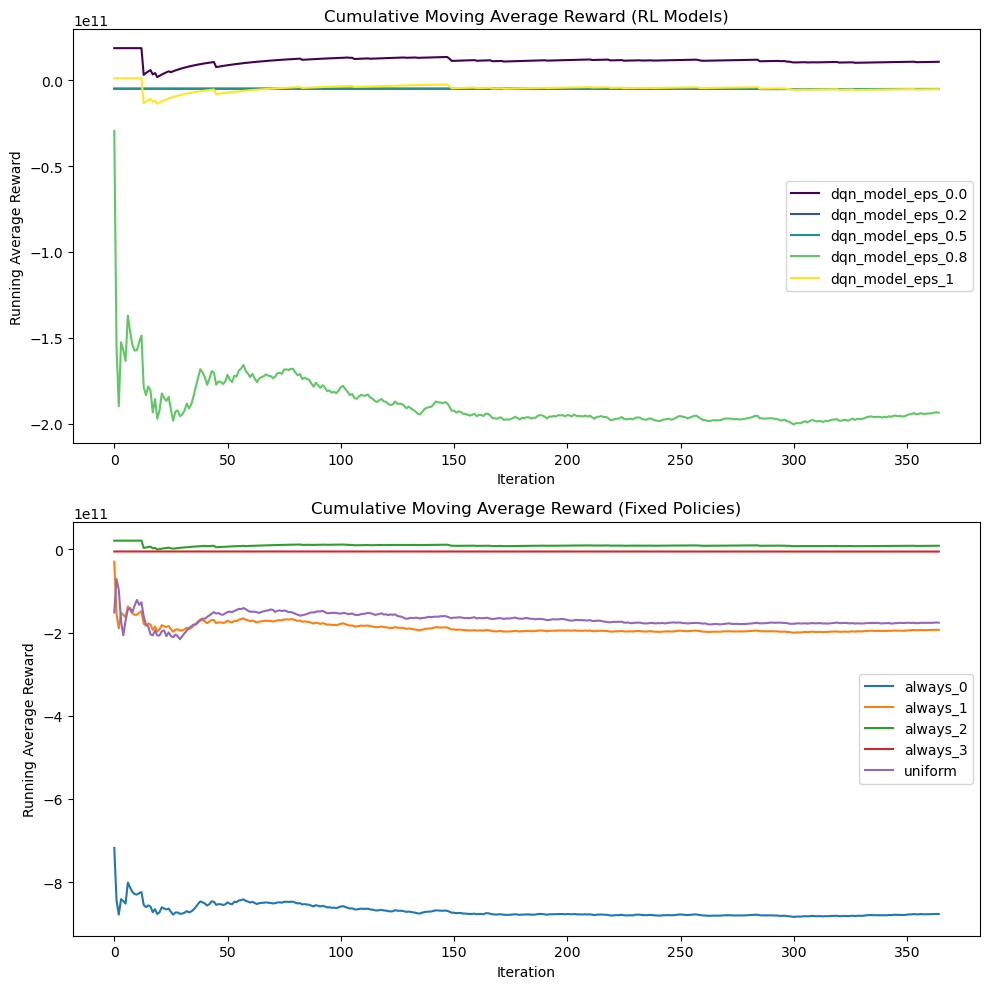

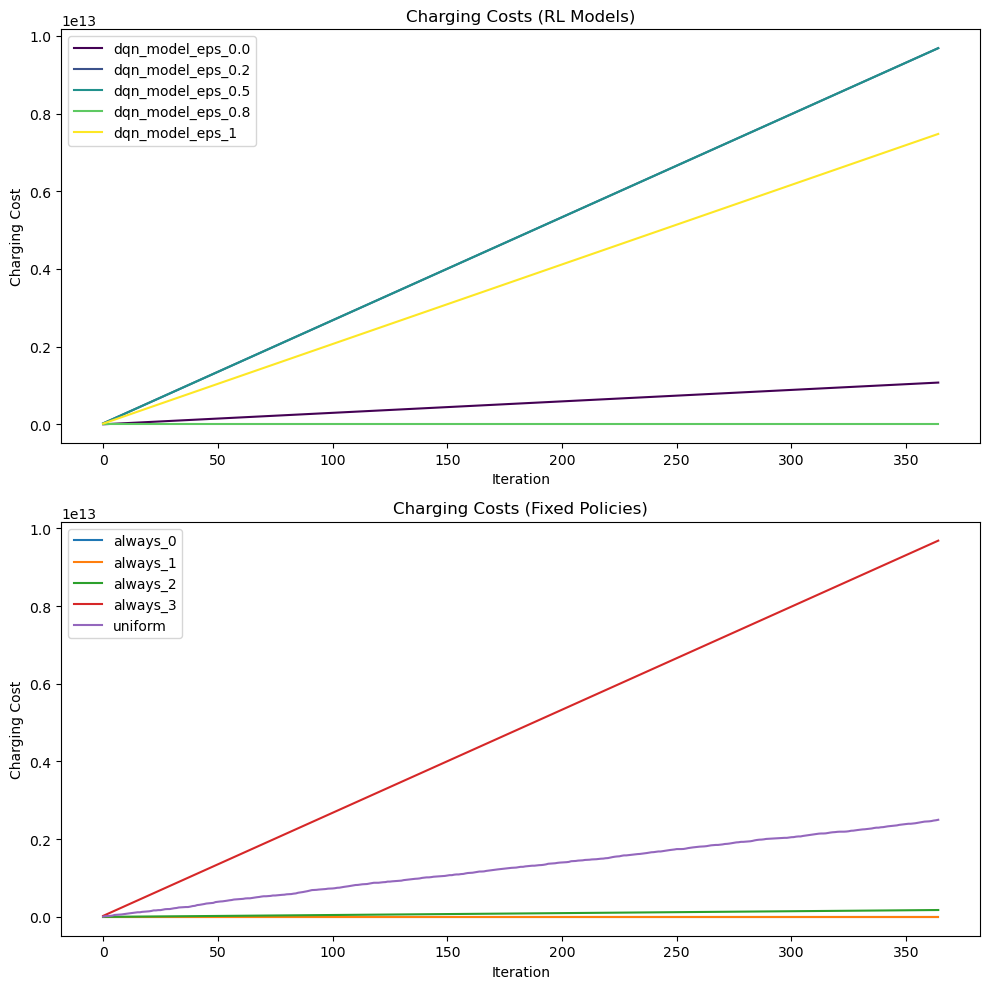

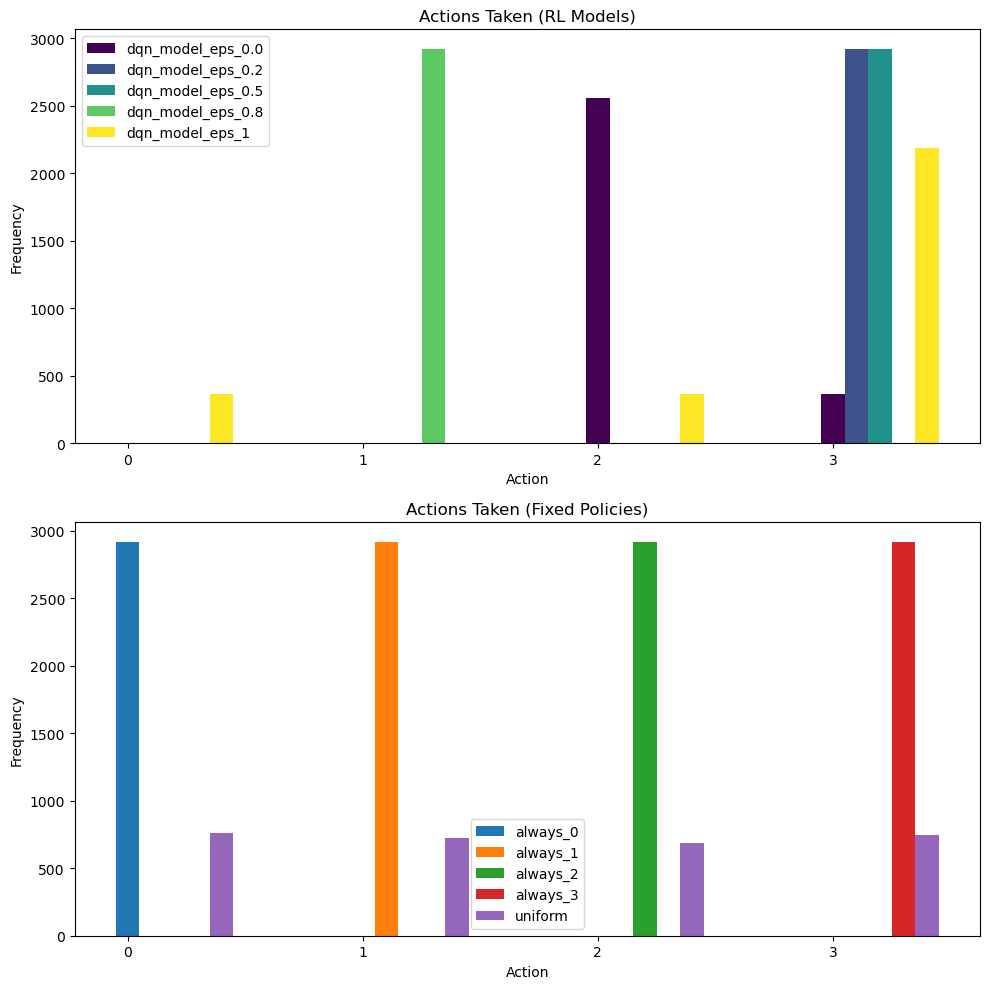

In [487]:
# PLOTS
#1. Running Average Rewards
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
colormap = plt.get_cmap('viridis')
colors = [colormap(i) for i in np.linspace(0, 1, n_models)]

# RL Models
for idx, model_file in enumerate(model_files):
    axes[0].plot(all_cumulative_rewards[idx], label=model_file, color=colors[idx]) # Setting color here

# Fixed Policies
for idx, policy_name in enumerate(fixed_policies, start=n_models):
    axes[1].plot(all_cumulative_rewards[idx], label=policy_name)

axes[0].set_title('Cumulative Moving Average Reward (RL Models)')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Running Average Reward')
axes[0].legend()

axes[1].set_title('Cumulative Moving Average Reward (Fixed Policies)')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Running Average Reward')
axes[1].legend()

plt.tight_layout()
plt.show()

# 2. Charging Costs
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# RL Models
for idx, model_file in enumerate(model_files):
    axes[0].plot([-1 * val for val in all_charging_costs[idx]], label=model_file, color=colors[idx])

# Fixed Policies
for idx, policy_name in enumerate(fixed_policies, start=n_models):
    axes[1].plot([-1 * val for val in all_charging_costs[idx]], label=policy_name)

axes[0].set_title('Charging Costs (RL Models)')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Charging Cost')
axes[0].legend()

axes[1].set_title('Charging Costs (Fixed Policies)')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Charging Cost')
axes[1].legend()

plt.tight_layout()
plt.show()

# 3. Action Distribution
x = np.arange(env.action_space.n)
width = 0.1

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# RL Models
for i, model_file in enumerate(model_files):
    actions = all_actions_taken[i]
    action_counts = np.zeros(env.action_space.n)
    for actions_iter in actions:
        unique_actions, counts = np.unique(actions_iter, return_counts=True)
        action_counts[unique_actions] += counts
    # Normalize color based on position in list
    color = colors[i]
    axes[0].bar(x + (i * width), action_counts, width=width, label=model_file, color=color)

# Fixed Policies
for i, policy_name in enumerate(fixed_policies, start=n_models):
    actions = all_actions_taken[i]
    action_counts = np.zeros(env.action_space.n)
    for actions_iter in actions:
        unique_actions, counts = np.unique(actions_iter, return_counts=True)
        action_counts[unique_actions] += counts
    axes[1].bar(x + ((i - n_models) * width), action_counts, width=width, label=policy_name)

axes[0].set_title('Actions Taken (RL Models)')
axes[0].set_xlabel('Action')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(env.action_space.n))
axes[0].legend()

axes[1].set_title('Actions Taken (Fixed Policies)')
axes[1].set_xlabel('Action')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(env.action_space.n))
axes[1].legend()

plt.tight_layout()
plt.show()

In [488]:
# Initialize the dataframe
agent_names = model_files + fixed_policies
actions_cols = range(env.action_space.n)
action_distribution_df = pd.DataFrame(index=agent_names, columns=actions_cols, dtype=float)

for idx, agent in enumerate(agent_names):
    actions = all_actions_taken[idx]
    action_counts = np.zeros(env.action_space.n)
    
    for actions_iter in actions:
        unique_actions, counts = np.unique(actions_iter, return_counts=True)
        action_counts[unique_actions] += counts

    # Convert action counts to percentages
    action_percentages = (action_counts / sum(action_counts)) * 100
    action_distribution_df.loc[agent] = action_percentages

# Display the DataFrame
action_distribution_df


,0,1,2,3
dqn_model_eps_0.0,0.00,0.00,87.50,12.50
dqn_model_eps_0.2,0.00,0.00,0.00,100.00
dqn_model_eps_0.5,0.00,0.00,0.00,100.00
dqn_model_eps_0.8,0.00,100.00,0.00,0.00
dqn_model_eps_1,12.50,0.00,12.50,75.00
always_0,100.00,0.00,0.00,0.00
always_1,0.00,100.00,0.00,0.00
always_2,0.00,0.00,100.00,0.00
always_3,0.00,0.00,0.00,100.00
uniform,26.03,24.86,23.63,25.48


In [489]:
# SUMMARY TABLES
# Find the best (minimum) total charging cost among RL models
best_charging_cost_rl = min([-all_charging_costs[i][-1] for i in range(len(model_files))])
import pandas as pd

# Format the floating point numbers in DataFrames
pd.set_option('display.float_format', '{:.2f}'.format)

# Compute table for the RL models
data_list = []

for i, model_file in enumerate(model_files):
    total_accumulated_reward = total_accumulated_rewards[i]
    relative_comparison = total_accumulated_reward / max(total_accumulated_rewards[0:5])
    energy_demand_not_met = energy_demand_not_met_counts[i]
    average_reward = total_accumulated_reward / n_sim_episodes
    total_cost = -all_charging_costs[i][-1]
    relative_charging_cost_comparison = total_cost / best_charging_cost_rl
    total_missed_demand = all_missed_demands[i]
    total_penalty = total_cost - total_accumulated_reward
    avg_missed_demand_per_occurrence = total_missed_demand / energy_demand_not_met if energy_demand_not_met != 0 else 0

    data_list.append({
        "Model": model_file,
        "Total Cumulative Reward": total_accumulated_reward,
        "Average Reward": average_reward,
        "Comparison Factor (Total Reward / Max(Total Reward))": relative_comparison,
        "No. of days with unmatched demand": energy_demand_not_met,
        "Total Charging Cost": total_cost,
        "Charging Cost Comparison": relative_charging_cost_comparison,        
        "Total Penalty": total_penalty,
        "Total Missed Demand (kW)": total_missed_demand,
        "Avg Missed Demand/Occurrence": avg_missed_demand_per_occurrence,
    })

# Convert to DataFrame
rl_df = pd.DataFrame(data_list)

# Compute table for the fixed policies
data_list_fixed_policies = []

for i, policy_name in enumerate(fixed_policies, start=n_models):
    total_accumulated_reward = total_accumulated_rewards[i]
    relative_comparison = total_accumulated_reward / max(total_accumulated_rewards[5:9])
    energy_demand_not_met = energy_demand_not_met_counts[i]
    average_reward = total_accumulated_reward / n_sim_episodes
    total_cost = -all_charging_costs[i][-1]
    relative_charging_cost_comparison = total_cost / best_charging_cost_fixed
    total_missed_demand = all_missed_demands[i]
    total_penalty = total_cost - total_accumulated_reward
    avg_missed_demand_per_occurrence = total_missed_demand / energy_demand_not_met if energy_demand_not_met != 0 else 0

    data_list_fixed_policies.append({
        "Model": policy_name,
        "Total Cumulative Reward": total_accumulated_reward,
        "Average Reward": average_reward,
        "Comparison Factor (Total Reward / Max(Total Reward))": relative_comparison,
        "No. of days with unmatched demand": energy_demand_not_met,
        "Total Charging Cost": total_cost,
        "Charging Cost Comparison": relative_charging_cost_comparison,
        "Total Penalty": total_penalty,
        "Total Missed Demand (kW)": total_missed_demand,
        "Avg Missed Demand/Occurrence": avg_missed_demand_per_occurrence
    })

# Convert to DataFrame
fixed_policies_df = pd.DataFrame(data_list_fixed_policies)

In [490]:
rl_df.sort_values(by='No. of days with unmatched demand', ascending=True)

,Model,Total Cumulative Reward,Average Reward,Comparison Factor (Total Reward / Max(Total Reward)),No. of days with unmatched demand,Total Charging Cost,Charging Cost Comparison,Total Penalty,Total Missed Demand (kW),Avg Missed Demand/Occurrence
1,dqn_model_eps_0.2,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,22026.47,11578839375229.44,1.49,1.49
2,dqn_model_eps_0.5,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,22026.47,11578839375229.44,1.49,1.49
4,dqn_model_eps_1,-1931462368795.15,-5291677722.73,-0.50,28,7475187298856.43,17004.49,9406649667651.59,59.45,2.12
0,dqn_model_eps_0.0,3877298218100.17,10622734844.11,1.00,35,1076516686711.96,2448.85,-2800781531388.22,74.77,2.14
3,dqn_model_eps_0.8,-70626556597298.20,-193497415335.06,-18.22,329,439600691.62,1.00,70626996197989.83,2489.62,7.57


In [491]:
fixed_policies_df.sort_values(by='No. of days with unmatched demand', ascending=True)

,Model,Total Cumulative Reward,Average Reward,Comparison Factor (Total Reward / Max(Total Reward)),No. of days with unmatched demand,Total Charging Cost,Charging Cost Comparison,Total Penalty,Total Missed Demand (kW),Avg Missed Demand/Occurrence
3,always_3,-1895989777827.98,-5194492541.99,-0.60,1,9682849597401.46,3584912846.13,11578839375229.44,1.49,1.49
2,always_2,3180982772632.04,8715021294.88,1.00,50,177347576639.93,65659969.14,-3003635195992.11,119.15,2.38
4,uniform,-64324095320728.81,-176230398138.98,-20.22,263,2499444974887.63,925377628.61,66823540295616.45,2232.22,8.49
1,always_1,-70626556597298.20,-193497415335.06,-22.20,329,439600691.62,162754.79,70626996197989.83,2489.62,7.57
0,always_0,-319997674880386.88,-876705958576.40,-100.60,365,2701.00,1.00,319997674883087.88,11157.79,30.57


In [492]:
# Concatenate RL and fixed policies dataframes
merged_df = pd.concat([rl_df, fixed_policies_df], ignore_index=True)

# Recompute the charging cost comparisons based on the entire dataset
best_charging_cost = min(merged_df['Total Charging Cost'])
merged_df['Charging Cost Comparison'] = merged_df['Total Charging Cost'] / best_charging_cost

# Recompute the relative comparison factor
max_cumulative_reward = max(merged_df['Total Cumulative Reward'])
merged_df['Comparison Factor (Total Reward / Max(Total Reward))'] = merged_df['Total Cumulative Reward'] / max_cumulative_reward

# If you want to sort the merged dataframe by any specific column (e.g., 'No. of days with unmatched demand')
sorted_merged_df = merged_df.sort_values(by='No. of days with unmatched demand')

sorted_merged_df


,Model,Total Cumulative Reward,Average Reward,Comparison Factor (Total Reward / Max(Total Reward)),No. of days with unmatched demand,Total Charging Cost,Charging Cost Comparison,Total Penalty,Total Missed Demand (kW),Avg Missed Demand/Occurrence
1,dqn_model_eps_0.2,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,3584912846.13,11578839375229.44,1.49,1.49
2,dqn_model_eps_0.5,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,3584912846.13,11578839375229.44,1.49,1.49
8,always_3,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,3584912846.13,11578839375229.44,1.49,1.49
4,dqn_model_eps_1,-1931462368795.15,-5291677722.73,-0.50,28,7475187298856.43,2767562865.18,9406649667651.59,59.45,2.12
0,dqn_model_eps_0.0,3877298218100.17,10622734844.11,1.00,35,1076516686711.96,398562268.31,-2800781531388.22,74.77,2.14
7,always_2,3180982772632.04,8715021294.88,0.82,50,177347576639.93,65659969.14,-3003635195992.11,119.15,2.38
9,uniform,-64324095320728.81,-176230398138.98,-16.59,263,2499444974887.63,925377628.61,66823540295616.45,2232.22,8.49
3,dqn_model_eps_0.8,-70626556597298.20,-193497415335.06,-18.22,329,439600691.62,162754.79,70626996197989.83,2489.62,7.57
6,always_1,-70626556597298.20,-193497415335.06,-18.22,329,439600691.62,162754.79,70626996197989.83,2489.62,7.57
5,always_0,-319997674880386.88,-876705958576.40,-82.53,365,2701.00,1.00,319997674883087.88,11157.79,30.57


In [493]:
# Identify the model with the minimum number of days with unmatched demand
min_unmatched_demand = merged_df['No. of days with unmatched demand'].min()
base_model = merged_df[merged_df['No. of days with unmatched demand'] == min_unmatched_demand].iloc[0]

# Use its charging cost as the base (denominator) for the charging cost comparison
base_charging_cost = base_model['Total Charging Cost']

# Compute the charging cost comparison for all models relative to this base charging cost
merged_df['Charging Cost Comparison w.r.t Min Unmatched Demand'] = merged_df['Total Charging Cost'] / base_charging_cost

# Display the updated merged dataframe
merged_df.sort_values(by='No. of days with unmatched demand')


,Model,Total Cumulative Reward,Average Reward,Comparison Factor (Total Reward / Max(Total Reward)),No. of days with unmatched demand,Total Charging Cost,Charging Cost Comparison,Total Penalty,Total Missed Demand (kW),Avg Missed Demand/Occurrence,Charging Cost Comparison w.r.t Min Unmatched Demand
1,dqn_model_eps_0.2,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,3584912846.13,11578839375229.44,1.49,1.49,1.00
2,dqn_model_eps_0.5,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,3584912846.13,11578839375229.44,1.49,1.49,1.00
8,always_3,-1895989777827.98,-5194492541.99,-0.49,1,9682849597401.46,3584912846.13,11578839375229.44,1.49,1.49,1.00
4,dqn_model_eps_1,-1931462368795.15,-5291677722.73,-0.50,28,7475187298856.43,2767562865.18,9406649667651.59,59.45,2.12,0.77
0,dqn_model_eps_0.0,3877298218100.17,10622734844.11,1.00,35,1076516686711.96,398562268.31,-2800781531388.22,74.77,2.14,0.11
7,always_2,3180982772632.04,8715021294.88,0.82,50,177347576639.93,65659969.14,-3003635195992.11,119.15,2.38,0.02
9,uniform,-64324095320728.81,-176230398138.98,-16.59,263,2499444974887.63,925377628.61,66823540295616.45,2232.22,8.49,0.26
3,dqn_model_eps_0.8,-70626556597298.20,-193497415335.06,-18.22,329,439600691.62,162754.79,70626996197989.83,2489.62,7.57,0.00
6,always_1,-70626556597298.20,-193497415335.06,-18.22,329,439600691.62,162754.79,70626996197989.83,2489.62,7.57,0.00
5,always_0,-319997674880386.88,-876705958576.40,-82.53,365,2701.00,1.00,319997674883087.88,11157.79,30.57,0.00


In [485]:
# Obviously: Simple environment -> In practice one would use more sophisticated environment models, a variety of learning methods including callbacks in training and ensemble methods for simulation. 

# Interesting observation that multiple agents learn "the safe" strategy of always charging at highest possible rate, which indeed leads to the minimum number of days with unmatched demand. 

# First observation regardless of RL: Just the fixed policy agents show the tradeoff between charging costs and missed energy demand with the given environment and parameters for demand modeling.
# -> The highest charging rate (due to the exponential charging cost function) leads to very high costs, while "ensuring" the minimum possible number of episodes with unmatched demand.
# -> The medium charging rate agent leads to significantly lower costs (90% less costs than highest charging rate) but misses demand on 50 episodes.

# The model with full exploration during training learns a strategy which finds a policy which uses all actions 3, 2 and 0 (75 / 12.5 / 12.5 relative frequency) and in the simulated scenarios has 23% less charging costs than the agents. 
# Did not fully meet energy demand on 28 (N=365) episodes with an average missed demand of 2.12 kw.

# The model with no exploration during training learns a strategy which chooses a mix of actions 2 and 3 ( 87.5 / 12.5 relative frequency) and in the simulated scenarios has 89% (!) less charging costs than "the safe" agents. 
# The model did not fully meet energy demand on 35 episodes (N=365) with an average missed demand of 2.14 kw.

# A simple heuristic in both cases, as well as the "only medium charge"-agent, case might be, for example, be to perform one fixed medium charge (18kW/h in 15 minutes = 4.5kw), which on average, would satisfy the missed demand while still having lower costs.